https://docs.opencv.org/4.5.0/d3/dc0/group__imgproc__shape.html

# Crater Detection & Identification

## Imports & Data

In [1]:
from craterdetection.common.camera import camera_matrix, crater_camera_homography
from craterdetection.common.coordinates import nadir_attitude
%config InlineBackend.figure_format = 'svg'

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import cv2
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import pandas as pd
from scipy.spatial.distance import cdist
from itertools import combinations, permutations, repeat
from functools import partial
import sklearn.neighbors
import h5py
from dataclasses import dataclass
import networkx as nx
from astropy.coordinates import spherical_to_cartesian
from src.detection.deepmoon import DeepMoon
from src.matching.projective_invariants import conic_matrix, scale_det
from src.matching import CoplanarInvariants, CraterDatabase
from src.matching.utils import cyclic_permutations, enhanced_pattern_shifting, is_clockwise, all_clockwise, \
    np_swap_columns, is_colinear
import craterdetection.common.constants as const


try:
    from VPU import OpenVINOHandler
except ImportError as e:
    print(f"OpenVINO variables not set up -> {e}")

torch.cuda.get_device_name(0)

OpenVINO variables not set up -> No module named 'VPU'


'GeForce RTX 3080'

In [3]:
# sd_input_images = np.load('../blobs/sd_input_images.npy').transpose(0, 3, 1, 2)
# sd_target_masks = np.load('../blobs/sd_target_masks.npy')
h5_craters = h5py.File(r"..\data\dev_craters.hdf5", "r")
h5_images = h5py.File(r"..\data\dev_images.hdf5", "r")

## Setup Model

In [4]:
net = DeepMoon()
checkpoint_path = '../blobs/DeepMoon.pth'
checkpoint = torch.load(checkpoint_path)
net.load_state_dict(checkpoint)
net.eval()

try:
    exp = OpenVINOHandler('DeepMoon', device='MYRIAD', root='../VPU/IR/')
except NameError:
    print("OpenVINOHandler could not be instantiated. See import cell above for more details.")

OpenVINOHandler could not be instantiated. See import cell above for more details.


## Output Post-Processing

### Crater Detection
Utilises thresholding + contour finding + ellipse fitting to return discrete crater detections with ellipticity < 0.1.

In [5]:
from craterdetection.detection.post_processing import crater_detection, draw_detections

### Test Crater Detection Pipeline

In [6]:
image_i = 30
crater_test = h5_craters[f'img_{image_i:05}/block0_values'][...]
df_target = pd.DataFrame(crater_test, columns=['diam', 'lat', 'long', 'x_pix', 'y_pix', 'diam_pix'])
img_test = h5_images['input_images'][image_i]/255
df_target.eval('kmperpix = diam / diam_pix', inplace=True)

target_mask = np.zeros_like(img_test)
for i, r in df_target.iterrows():
    center_coordinates = (round(r['x_pix']), round(r['y_pix']))
    axes_length = (round(r['diam_pix']/2), round(r['diam_pix']/2))
    angle = 0
    target_mask = cv2.ellipse(target_mask, center_coordinates, axes_length, 
               angle, 0, 360, (255, 255, 255), 1)

In [7]:
%%time
batch = img_test.reshape(1, 1, 256, 256)
try:
    out = exp.infer(batch)
except NameError:
    print("OpenVINOHandler is not available. Using PyTorch for inference...")
    with torch.no_grad():
        out = net(torch.Tensor(batch))
        out = out.numpy()

OpenVINOHandler is not available. Using PyTorch for inference...
Wall time: 467 ms


49 craters detected!
Wall time: 213 ms


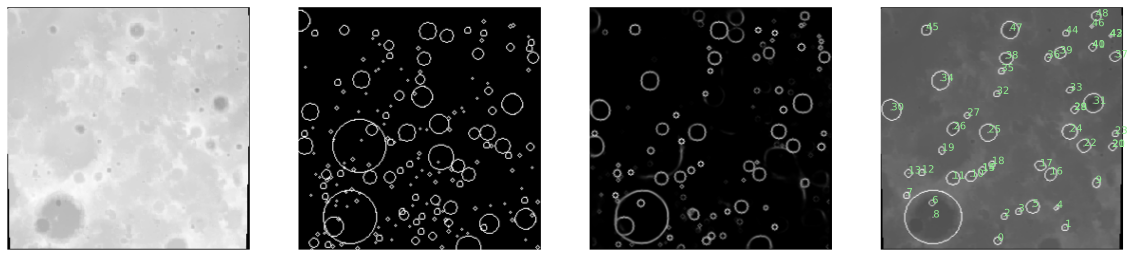

In [8]:
%%time
df_detections = crater_detection(out[0, 0], threshold_lower=80)

img_out = [
    batch[0, 0],
    target_mask,
    out[0, 0],
    255*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(20, 15))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    
for index, r in df_detections.iterrows():
    axes[-1].text(r['x_pix'], r['y_pix'], str(index), color='lightgreen')

print(f"{len(df_detections)} craters detected!")
fig.savefig('output/crater_detection.png')

In [9]:
df_detections.head(5)

,x_pix,y_pix,a_pix,b_pix,angle_pix,e,r_pix,diam_pix
0,123.117233,245.882767,3.699146,3.997786,45.000000,0.074701,3.848466,7.696931
1,194.500000,231.500000,2.549510,2.549510,0.000000,0.000000,2.549510,5.099020
2,130.000000,220.000000,2.920516,2.920516,0.000000,0.000000,2.920516,5.841032
3,145.000000,215.000000,2.920516,2.920516,0.000000,0.000000,2.920516,5.841032
4,185.487106,211.361206,2.400169,2.504197,45.647762,0.041541,2.452183,4.904366


# Crater Matching

From [_Lunar Crater Identification from Digital Images_, J. Christian et al.](http://arxiv.org/abs/2009.01228):

Projective invariants for triads of coplanar conics:

Consider the determinant of a _net_ of three conics:

$$ |\lambda A_i + \mu A_j + \sigma A_k| = \Theta_1\lambda^3 + \Theta_2\lambda^2\mu + \Theta_3\lambda\mu^2 + \Theta_4\mu^3 + \Theta_5\lambda^2\sigma + \Theta_6\lambda\sigma^2 + \Theta_7\sigma^3 + \Theta_8\mu^2\sigma + \Theta_9\mu\sigma^2 + \Theta_{10}\lambda\mu\sigma $$

with $$|A_i| = |A_j| = |A_k| = 1$$

using $$ \left(\sqrt[^n]{\frac{1}{|A|}}\right) A = A'$$

results in

$$ I_{ij} = Tr[A_i^{-1}A_j] $$
$$ I_{ji} = Tr[A_j^{-1}A_i] $$
$$ I_{ik} = Tr[A_i^{-1}A_k] $$
$$ I_{ki} = Tr[A_k^{-1}A_i] $$
$$ I_{jk} = Tr[A_j^{-1}A_k] $$
$$ I_{kj} = Tr[A_k^{-1}A_j] $$
$$ I_{ijk} = Tr{[(A_j + A_k)^* - (A_j - A_k)^*]A_i}$$

In [10]:
x_pix, y_pix, a_pix, b_pix, psi_pix, e, r, d = df_detections.to_numpy().T
crater_match_id = df_detections.index.to_numpy()

In [11]:
from craterdetection.matching.database import load_craters, gen_ENU_coordinates, _gen_local_cartesian_coords
df_craters = load_craters("../data/lunar_crater_database_robbins_2018.csv", latlims=[-20, 20], longlims=[0, 30], diamlims=[4, 40])
db = CraterDatabase.from_df(df_craters)

db_i, db_j, db_k, db_features = db.get_features()

#### Verification

In [12]:
xy_target = df_target[['x_pix', 'y_pix']].to_numpy()
df_matched = df_target.iloc[np.argmin(cdist(df_detections[['x_pix', 'y_pix']].to_numpy(), xy_target), axis=1)]
df_matched.columns = [s+"_t" for s in df_matched.columns]
df_matched = pd.concat([df_detections, df_matched.reset_index(drop=True)], axis=1)
df_matched['radius_t'] = df_matched['diam_t']/2
df_matched['angle_t'] = 0.
df_matched['id'] = df_matched.index
df_matched.head(5)

,x_pix,y_pix,a_pix,b_pix,angle_pix,e,r_pix,diam_pix,diam_t,lat_t,long_t,x_pix_t,y_pix_t,diam_pix_t,kmperpix_t,radius_t,angle_t,id
0,123.117233,245.882767,3.699146,3.997786,45.000000,0.074701,3.848466,7.696931,20.707325,-13.238278,9.426835,122.949033,246.470338,8.710447,2.377298,10.353662,0.0,0
1,194.500000,231.500000,2.549510,2.549510,0.000000,0.000000,2.549510,5.099020,15.494879,-12.081084,15.186204,195.127710,232.023781,6.517854,2.377298,7.747440,0.0,1
2,130.000000,220.000000,2.920516,2.920516,0.000000,0.000000,2.920516,5.841032,15.958792,-11.166071,10.003159,130.171874,220.181044,6.712997,2.377298,7.979396,0.0,2
3,145.000000,215.000000,2.920516,2.920516,0.000000,0.000000,2.920516,5.841032,13.530772,-10.790327,11.227828,145.617314,215.415483,5.691661,2.377298,6.765386,0.0,3
4,185.487106,211.361206,2.400169,2.504197,45.647762,0.041541,2.452183,4.904366,10.975239,-10.480187,14.413555,185.789469,211.611958,4.616687,2.377298,5.487619,0.0,4


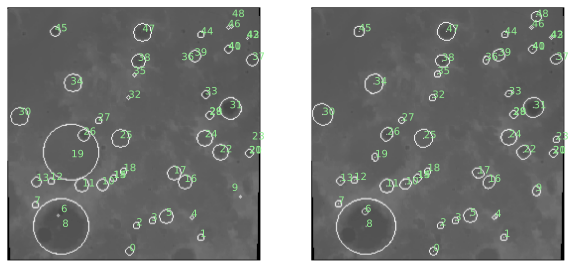

In [13]:
img_matched = np.zeros_like(batch[0, 0])
for index, r in df_matched.iterrows():
    center_coordinates = (round(r['x_pix_t']), round(r['y_pix_t']))
    axes_length = (round(r['diam_pix_t']/2), round(r['diam_pix_t']/2))
    angle = 0
    img_matched = cv2.ellipse(img_matched, center_coordinates, axes_length, 
               angle, 0, 360, (255, 255, 255), 1)

img_out = [
    255*batch[0, 0]+img_matched,
    255*batch[0, 0]+draw_detections(df_detections)
]

fig, axes = plt.subplots(1, len(img_out), figsize=(10, 10))

for ax, img in zip(axes, img_out):
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')
    for index, r in df_detections.iterrows():
        ax.text(r['x_pix'], r['y_pix'], str(index), color='lightgreen')
